In [124]:
pip install --upgrade mxnet~=1.7 gluonts

In [125]:
# Third-party imports
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [126]:
# gluon datasets
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

In [127]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5']


In [128]:
pip install mxnet

In [130]:
dataset_nasa = pd.read_csv('DOE-551-600-10DU-01_2.csv')

In [131]:
dataset_nasa


,index,Test_Time(s),Unnamed: 2,Step_Time(s),Cycle_Index,Step_Index,Voltage,Test_Time(s).1,Step_Time(s).1,Cycle_Index.1,Step_Index.1,Current,Test_Time(s).2,Step_Time(s).2,Cycle_Index.2,Step_Index.2,Charge_Capacity,Test_Time(s).3,Step_Time(s).3,Cycle_Index.3,Step_Index.3,Discharge_Capacity,Test_Time(s).4,Step_Time(s).4,Cycle_Index.4,Step_Index.4
0,0,120.002100,NaN,120.0020,1,1,3.578289,120.002100,120.0020,1,1,0.000000,120.002100,120.0020,1,1,0.000000,120.002100,120.0020,1,1,0.000000,120.002100,120.0020,1,1
1,1,240.004200,NaN,240.0041,1,1,3.578400,240.004200,240.0041,1,1,0.000000,240.004200,240.0041,1,1,0.000000,240.004200,240.0041,1,1,0.000000,240.004200,240.0041,1,1
2,2,360.003300,NaN,360.0032,1,1,3.580041,360.003300,360.0032,1,1,0.000000,360.003300,360.0032,1,1,0.000000,360.003300,360.0032,1,1,0.000000,360.003300,360.0032,1,1
3,3,480.005600,NaN,480.0055,1,1,3.581675,480.005600,480.0055,1,1,0.000000,480.005600,480.0055,1,1,0.000000,480.005600,480.0055,1,1,0.000000,480.005600,480.0055,1,1
4,4,600.000900,NaN,600.0008,1,1,3.582434,600.000900,600.0008,1,1,0.000000,600.000900,600.0008,1,1,0.000000,600.000900,600.0008,1,1,0.000000,600.000900,600.0008,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3953,3953,454963.238852,NaN,120.0033,50,6,3.609489,454963.238852,120.0033,50,6,0.000000,454963.238852,120.0033,50,6,2.441618,454963.238852,120.0033,50,6,2.441629,454963.238852,120.0033,50,6
3954,3954,455083.237752,NaN,240.0022,50,6,3.642449,455083.237752,240.0022,50,6,0.000000,455083.237752,240.0022,50,6,2.441618,455083.237752,240.0022,50,6,2.441629,455083.237752,240.0022,50,6
3955,3955,455143.238952,NaN,300.0034,50,6,3.650748,455143.238952,300.0034,50,6,0.000000,455143.238952,300.0034,50,6,2.441618,455143.238952,300.0034,50,6,2.441629,455143.238952,300.0034,50,6
3956,3956,455263.394832,NaN,120.0043,51,8,4.189424,455263.394832,120.0043,51,8,3.259819,455263.394832,120.0043,51,8,0.108659,455263.394832,120.0043,51,8,0.000000,455263.394832,120.0043,51,8


In [273]:
df = pd.DataFrame(dataset_nasa)
cols = [0,11]
df = df[df.columns[cols]]

In [274]:
df

,index,Current
0,0,0.000000
1,1,0.000000
2,2,0.000000
3,3,0.000000
4,4,0.000000
...,...,...
3953,3953,0.000000
3954,3954,0.000000
3955,3955,0.000000
3956,3956,3.259819


In [275]:
df1 = df.to_numpy()

In [276]:
train_size = int(len(df1)*0.8)
test_size = len(df1) - train_size
train = df1[1:train_size,:]
test = df1[train_size:len(df1)]

In [277]:
train_size

3166

In [278]:
train_set = pd.DataFrame(train)

In [279]:
train_set

,0,1
0,1.0,0.000000
1,2.0,0.000000
2,3.0,0.000000
3,4.0,0.000000
4,5.0,0.000000
...,...,...
3160,3161.0,-2.282021
3161,3162.0,-2.282184
3162,3163.0,0.000000
3163,3164.0,0.000000


In [280]:
test_set = pd.DataFrame(test)

In [281]:
test_set

,0,1
0,3166.0,3.301756
1,3167.0,3.259960
2,3168.0,3.260023
3,3169.0,3.260138
4,3170.0,3.259851
...,...,...
787,3953.0,0.000000
788,3954.0,0.000000
789,3955.0,0.000000
790,3956.0,3.259819


In [282]:
df.columns

Index(['index', 'Current'], dtype='object')

In [283]:
df_input = df[['index','Current']]

In [284]:
df_input = df_input.set_index('index')

In [285]:
train_time = 949
prediction_length = 949
freq = "2min"

In [286]:
from gluonts.dataset.common import ListDataset
train_data = ListDataset(
    [{"start": df_input.index[0], "target": df_input.Current[:train_time] }],
    freq = "2min"
)

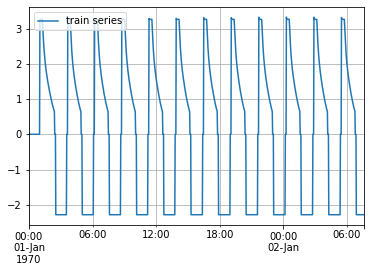

In [287]:
entry = next(iter(train_data))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.savefig("fig1.pdf",bbox_inches="tight")
plt.show()

In [289]:
test_data = ListDataset(
    [{"start": df_input.index[0], "target": df_input.Current[:]}],
    freq = "2min"
)

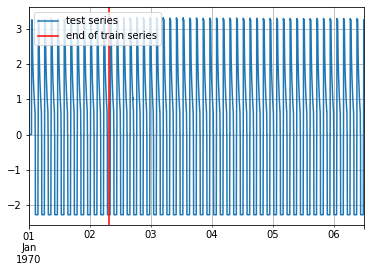

In [290]:
entry = next(iter(test_data))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.savefig("fig2.pdf",bbox_inches="tight")
plt.show()

In [291]:
print(f"Length of forecasting window in test dataset:{len(test_series)-len(train_series)}")
print(f"Frequency of the time series:{freq}")

Length of forecasting window in test dataset:3009
Frequency of the time series:2min


In [292]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.mx.trainer import Trainer

In [293]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=250,
    context_length=50,
    freq="2min",
    trainer=Trainer(ctx="cpu", 
                    epochs=5, 
                    learning_rate=1e-3, 
                    num_batches_per_epoch=100
                   )
)

In [294]:
predictor = estimator.train(train_data)

100%|██████████| 100/100 [00:01<00:00, 79.41it/s, epoch=5/5, avg_epoch_loss=0.594]


In [295]:
from gluonts.evaluation.backtest import make_evaluation_predictions

In [296]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=500,  # number of sample paths we want for evaluation 100
)

In [297]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [298]:
# first entry of the time series list
ts_entry = tss[0]

In [299]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(-1,)

array([0., 0., 0., 0., 0.], dtype=float32)

In [300]:
# first entry of dataset.test
dataset_test_entry = next(iter(test_data))

In [301]:
# first 5 values
dataset_test_entry['target'][:5]

array([0., 0., 0., 0., 0.], dtype=float32)

In [302]:
# first entry of the forecast list
forecast_entry = forecasts[0]

In [303]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 500
Dimension of samples: (500, 250)
Start date of the forecast window: 1970-01-06 03:36:00
Frequency of the time series: 2min


In [304]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [-2.29520798e+00 -2.22211289e+00 -2.27021742e+00 -2.33671641e+00
 -2.14415884e+00 -1.91683352e+00 -1.56738365e+00 -1.42152727e+00
 -1.40405810e+00 -8.99448931e-01 -5.82323134e-01  8.90691996e-01
 -4.62713987e-01  7.49384046e-01  1.16698563e+00  1.24327135e+00
  1.59537125e+00  1.81377649e+00  2.05410504e+00  2.13439775e+00
  2.23828554e+00  2.14890385e+00  1.91877961e+00  2.16756654e+00
  1.73337197e+00  1.98868501e+00  1.62986612e+00  1.51694369e+00
  1.74410427e+00  1.67755747e+00  1.56303167e+00  1.52744830e+00
  1.41547382e+00  1.39550602e+00  1.27822661e+00  1.23102283e+00
  1.22718954e+00  1.15462625e+00  1.13644767e+00  1.09332323e+00
  1.06982613e+00  1.03660560e+00  1.00732291e+00  8.74928236e-01
  8.69694829e-01  8.15890074e-01  7.51629949e-01  7.33449101e-01
  6.83431387e-01  3.02794129e-01 -8.44720111e-04 -4.77039784e-01
 -1.08423865e+00 -1.70272160e+00 -2.21959400e+00 -2.28738952e+00
 -2.39070559e+00 -2.28524661e+00 -2.21902609e+00 -2.22450900e+

In [305]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 500
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.ylim(-3,4)
    plt.legend(legend, loc="upper left")
    plt.savefig("fig3.pdf",bbox_inches="tight")
    plt.show()

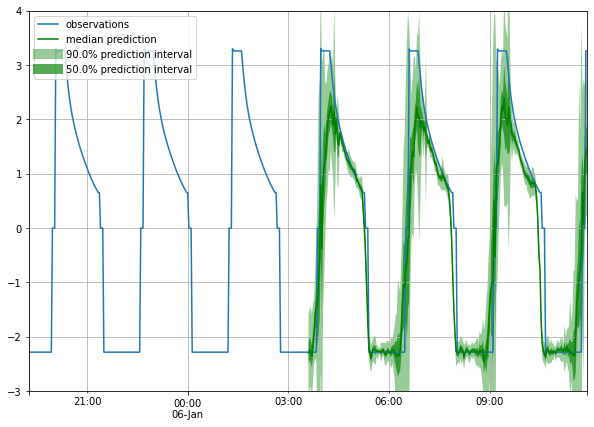

In [306]:
plot_prob_forecasts(ts_entry, forecast_entry)

In [307]:
from gluonts.evaluation import Evaluator

In [308]:
evaluator = Evaluator(quantiles=[0.5,0.1,0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_data))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 28.01it/s]


In [309]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 0.7358414306640625,
    "abs_error": 126.35072326660156,
    "abs_target_sum": 475.7149658203125,
    "abs_target_mean": 1.90285986328125,
    "seasonal_error": 1.7706467144620148,
    "MASE": 0.2854340670775568,
    "MAPE": 0.2198846475526235,
    "sMAPE": 0.4165400390625,
    "MSIS": 3.186331930577523,
    "QuantileLoss[0.5]": 126.3507197201252,
    "Coverage[0.5]": 0.332,
    "QuantileLoss[0.1]": 43.45579291880131,
    "Coverage[0.1]": 0.012,
    "QuantileLoss[0.9]": 101.00717009305956,
    "Coverage[0.9]": 0.644,
    "RMSE": 0.8578120019351924,
    "NRMSE": 0.4508014586297491,
    "ND": 0.2656017412627016,
    "wQuantileLoss[0.5]": 0.26560173380765684,
    "wQuantileLoss[0.1]": 0.09134838304669916,
    "wQuantileLoss[0.9]": 0.2123270810261035,
    "mean_absolute_QuantileLoss": 90.2712275773287,
    "mean_wQuantileLoss": 0.18975906596015316,
    "MAE_Coverage": 0.17066666666666666,
    "OWA": NaN
}


In [310]:
item_metrics

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,MSIS,QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.9],Coverage[0.9]
0,NaN,0.735841,126.350723,475.714966,1.90286,1.770647,0.285434,0.219885,0.41654,3.186332,126.35072,0.332,43.455793,0.012,101.00717,0.644


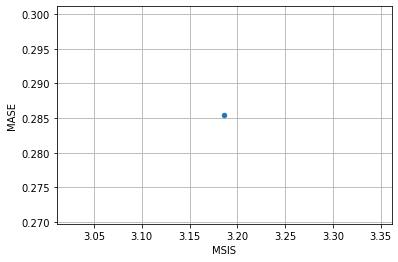

In [311]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.savefig("fig4.pdf",bbox_inches="tight")
plt.show()

In [312]:
# own forecast model

In [313]:
class MyNetwork(gluon.HybridBlock):
    def __init__(self, prediction_length, num_cells, **kwargs):
        super().__init__(**kwargs)
        self.prediction_length = prediction_length
        self.num_cells = num_cells

        with self.name_scope():
            # Set up a 3 layer neural network that directly predicts the target values
            self.nn = mx.gluon.nn.HybridSequential()
            self.nn.add(mx.gluon.nn.Dense(units=820, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=820, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=self.prediction_length, activation='relu'))


class MyTrainNetwork(MyNetwork):
    def hybrid_forward(self, F, past_target, future_target):
        prediction = self.nn(past_target)
        # calculate L1 loss with the future_target to learn the median
        return (prediction - future_target).abs().mean(axis=-1)


class MyPredNetwork(MyTrainNetwork):
    # The prediction network only receives past_target and returns predictions
    def hybrid_forward(self, F, past_target):
        prediction = self.nn(past_target)
        return prediction.expand_dims(axis=1)

In [315]:
def plot_prob_forecasts_2(ts_entry, forecast_entry):
    plot_length = 500
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.ylim(-3,4)
    plt.legend(legend, loc="upper left")
    plt.savefig("fig5.pdf",bbox_inches="tight")
    plt.show()

In [316]:
from functools import partial
from mxnet.gluon import HybridBlock
from gluonts.core.component import validated
from gluonts.dataset.loader import TrainDataLoader
from gluonts.model.predictor import Predictor
from gluonts.mx.batchify import as_in_context, batchify
from gluonts.mx.model.estimator import GluonEstimator
from gluonts.mx.model.predictor import RepresentableBlockPredictor
from gluonts.mx.trainer import Trainer
from gluonts.mx.util import copy_parameters, get_hybrid_forward_input_names
from gluonts.transform import (
    ExpectedNumInstanceSampler,
    Transformation,
    InstanceSplitter,
    TestSplitSampler,
    SelectFields,
    Chain
)

In [317]:
class MyEstimator(GluonEstimator):
    @validated()
    def __init__(
        self,
        prediction_length: int,
        context_length: int,
        freq: str,
        num_cells: int,
        batch_size: int = 32,
        trainer: Trainer = Trainer()
    ) -> None:
        super().__init__(trainer=trainer, batch_size=batch_size)
        self.prediction_length = prediction_length
        self.context_length = context_length
        self.freq = freq
        self.num_cells = num_cells

    def create_transformation(self):
        return Chain([])

    def create_training_data_loader(self, dataset, **kwargs):
        instance_splitter = InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            instance_sampler=ExpectedNumInstanceSampler(
                num_instances=1,
                min_future=self.prediction_length
            ),
            past_length=self.context_length,
            future_length=self.prediction_length,
        )
        input_names = get_hybrid_forward_input_names(MyTrainNetwork)
        return TrainDataLoader(
            dataset=dataset,
            transform=instance_splitter + SelectFields(input_names),
            batch_size=self.batch_size,
            stack_fn=partial(batchify, ctx=self.trainer.ctx, dtype=self.dtype),
            decode_fn=partial(as_in_context, ctx=self.trainer.ctx),
            **kwargs,
        )

    def create_training_network(self) -> MyTrainNetwork:
        return MyTrainNetwork(
            prediction_length=self.prediction_length,
            num_cells = self.num_cells
        )

    def create_predictor(
        self, transformation: Transformation, trained_network: HybridBlock
    ) -> Predictor:
        prediction_splitter = InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            instance_sampler=TestSplitSampler(),
            past_length=self.context_length,
            future_length=self.prediction_length,
        )

        prediction_network = MyPredNetwork(
            prediction_length=self.prediction_length,
            num_cells=self.num_cells
        )

        copy_parameters(trained_network, prediction_network)

        return RepresentableBlockPredictor(
            input_transform=transformation + prediction_splitter,
            prediction_net=prediction_network,
            batch_size=self.trainer.batch_size,
            freq=self.freq,
            prediction_length=self.prediction_length,
            ctx=self.trainer.ctx,
        )

In [318]:

# define the parameters of the dataset
custom_ds_metadata = {
    'num_series': 1,
    'num_steps': 1901,
    'prediction_length': 100,
    'freq': '2min',
    'start': [
        pd.Timestamp("01-01-2019", freq='2min')
        for _ in range(100)
    ]
}

In [339]:
estimator = MyEstimator(
    prediction_length=250,     #custom_ds_metadata['prediction_length'],
    context_length = custom_ds_metadata['prediction_length'],
    freq=custom_ds_metadata['freq'],
    num_cells=40, #40
    trainer=Trainer(
        ctx="cpu",
        epochs=5,
        learning_rate=1e-3, #-3
        hybridize=False,
        num_batches_per_epoch=2000
    )
)

In [340]:
from gluonts.dataset.field_names import FieldName
[f"FieldName.{k} = '{v}'" for k, v in FieldName.__dict__.items() if not k.startswith('_')]

["FieldName.ITEM_ID = 'item_id'",
 "FieldName.START = 'start'",
 "FieldName.TARGET = 'target'",
 "FieldName.FEAT_STATIC_CAT = 'feat_static_cat'",
 "FieldName.FEAT_STATIC_REAL = 'feat_static_real'",
 "FieldName.FEAT_DYNAMIC_CAT = 'feat_dynamic_cat'",
 "FieldName.FEAT_DYNAMIC_REAL = 'feat_dynamic_real'",
 "FieldName.PAST_FEAT_DYNAMIC_REAL = 'past_feat_dynamic_real'",
 "FieldName.FEAT_DYNAMIC_REAL_LEGACY = 'dynamic_feat'",
 "FieldName.FEAT_DYNAMIC = 'feat_dynamic'",
 "FieldName.PAST_FEAT_DYNAMIC = 'past_feat_dynamic'",
 "FieldName.FEAT_TIME = 'time_feat'",
 "FieldName.FEAT_CONST = 'feat_dynamic_const'",
 "FieldName.FEAT_AGE = 'feat_dynamic_age'",
 "FieldName.OBSERVED_VALUES = 'observed_values'",
 "FieldName.IS_PAD = 'is_pad'",
 "FieldName.FORECAST_START = 'forecast_start'",
 "FieldName.TARGET_DIM_INDICATOR = 'target_dimension_indicator'"]

In [341]:
predictor = estimator.train(train_data)

100%|██████████| 2000/2000 [00:35<00:00, 56.71it/s, epoch=5/5, avg_epoch_loss=1.04]


In [342]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [343]:
forecasts = list(forecast_it)
tss = list(ts_it)

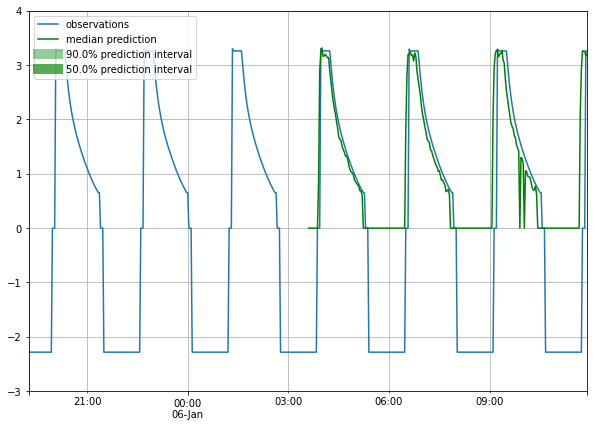

In [344]:
plot_prob_forecasts_2(tss[0], forecasts[0])

In [345]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_data))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 26.10it/s]


In [346]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 2.8508623046875,
    "abs_error": 312.02294921875,
    "abs_target_sum": 475.7149658203125,
    "abs_target_mean": 1.90285986328125,
    "seasonal_error": 1.7706467144620148,
    "MASE": 0.7048790629327852,
    "MAPE": 0.5801146394821234,
    "sMAPE": 1.1275990804036458,
    "MSIS": 28.19516251731141,
    "QuantileLoss[0.1]": 513.6243173360825,
    "Coverage[0.1]": 0.48,
    "QuantileLoss[0.5]": 312.02294051647186,
    "Coverage[0.5]": 0.48,
    "QuantileLoss[0.9]": 110.42156369686126,
    "Coverage[0.9]": 0.48,
    "RMSE": 1.6884496749052071,
    "NRMSE": 0.8873221341658242,
    "ND": 0.6559031597433653,
    "wQuantileLoss[0.1]": 1.0796892135827596,
    "wQuantileLoss[0.5]": 0.6559031414503143,
    "wQuantileLoss[0.9]": 0.2321170693178692,
    "mean_absolute_QuantileLoss": 312.02294051647186,
    "mean_wQuantileLoss": 0.6559031414503144,
    "MAE_Coverage": 0.2733333333333334,
    "OWA": NaN
}


In [347]:
item_metrics.head(10)

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,2.850862,312.022949,475.714966,1.90286,1.770647,0.704879,0.580115,1.127599,28.195163,513.624317,0.48,312.022941,0.48,110.421564,0.48


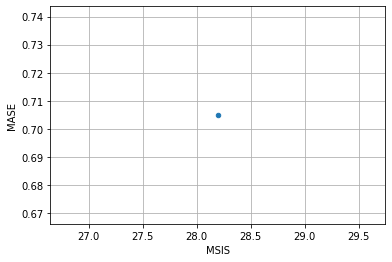

In [348]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.savefig("fig6.pdf",bbox_inches="tight")
plt.show()